### Complejidad - Práctico 6 - Criticalidad auto organizada en crashes financieros
#### Lautaro Giordano

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
import pywt
from scipy import stats

In [3]:
# Descarga los datos históricos del S&P 500
ticker = "^GSPC"  # Símbolo del S&P 500 en Yahoo Finance
sp500 = yf.download(ticker, start="1980-01-01", end="2024-01-01", interval="1d")

# Mostrar las primeras filas de los datos
print(sp500.head())

[*********************100%***********************]  1 of 1 completed

Price                       Adj Close       Close        High         Low  \
Ticker                          ^GSPC       ^GSPC       ^GSPC       ^GSPC   
Date                                                                        
1980-01-02 00:00:00+00:00  105.760002  105.760002  108.430000  105.290001   
1980-01-03 00:00:00+00:00  105.220001  105.220001  106.080002  103.260002   
1980-01-04 00:00:00+00:00  106.519997  106.519997  107.080002  105.089996   
1980-01-07 00:00:00+00:00  106.809998  106.809998  107.800003  105.800003   
1980-01-08 00:00:00+00:00  108.949997  108.949997  109.290001  106.290001   

Price                      Open    Volume  
Ticker                    ^GSPC     ^GSPC  
Date                                       
1980-01-02 00:00:00+00:00   0.0  40610000  
1980-01-03 00:00:00+00:00   0.0  50480000  
1980-01-04 00:00:00+00:00   0.0  39130000  
1980-01-07 00:00:00+00:00   0.0  44500000  
1980-01-08 00:00:00+00:00   0.0  53390000  


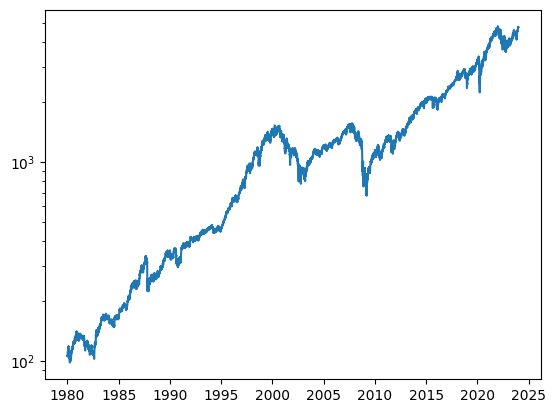

In [4]:
plt.plot(sp500["Adj Close"])
plt.yscale("log")

In [6]:
# Calcular los retornos logarítmicos
sp500['Log Return'] = np.log(sp500['Adj Close'] / sp500['Adj Close'].shift(1))

# Eliminar valores NaN resultantes del desplazamiento
sp500.dropna(inplace=True)

# Mostrar las primeras filas de los datos con retornos
print(sp500[['Adj Close', 'Log Return']].head())

Price                       Adj Close Log Return
Ticker                          ^GSPC           
Date                                            
1980-01-03 00:00:00+00:00  105.220001  -0.005119
1980-01-04 00:00:00+00:00  106.519997   0.012279
1980-01-07 00:00:00+00:00  106.809998   0.002719
1980-01-08 00:00:00+00:00  108.949997   0.019838
1980-01-09 00:00:00+00:00  109.050003   0.000917


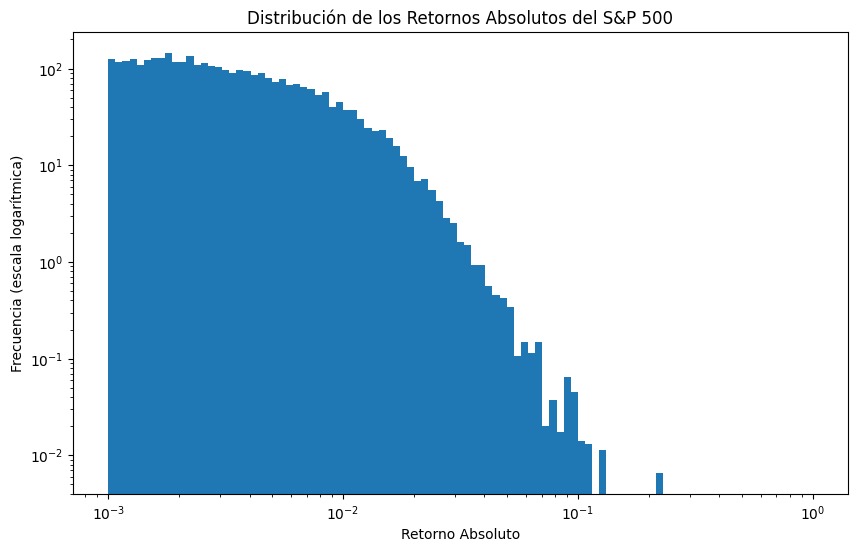

In [42]:
# Histograma de los retornos absolutos
plt.figure(figsize=(10, 6))

bins = np.logspace(-3, 0, 100)

plt.hist(np.abs(sp500['Log Return']), bins=bins, density=True)
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Retorno Absoluto")
plt.ylabel("Frecuencia (escala logarítmica)")
plt.title("Distribución de los Retornos Absolutos del S&P 500")
plt.show()

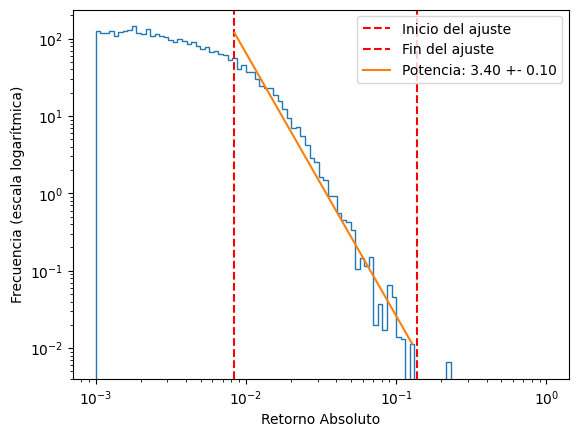

In [43]:
bins = np.logspace(-3, 0, 100)
counts, bins, _ = plt.hist(np.abs(sp500['Log Return']), bins=bins, density=True, histtype='step')
plt.xscale("log")
plt.yscale("log")

x = (bins[:-1] + bins[1:]) / 2

# Ajustar una distribución de potencia a los datos
start = 30
end = 70
plt.axvline(x[start], color='r', linestyle='--', label='Inicio del ajuste')
plt.axvline(x[end], color='r', linestyle='--', label='Fin del ajuste')

x_fit = x[start:end]
y_fit = counts[start:end]

# Borro los valores 0 para que no haya problemas al hacer el ajuste
x_fit = x_fit[y_fit > 0]
y_fit = y_fit[y_fit > 0]

popt, pcov = np.polyfit(np.log(x_fit), np.log(y_fit), 1, cov=True)
alpha = -popt[0]
beta = np.exp(popt[1])

plt.plot(x_fit, beta * x_fit ** (-alpha), label=f'Potencia: {alpha:.2f} +- {np.sqrt(pcov[0, 0]):.2f}')

plt.xlabel("Retorno Absoluto")
plt.ylabel("Frecuencia (escala logarítmica)");

plt.legend()


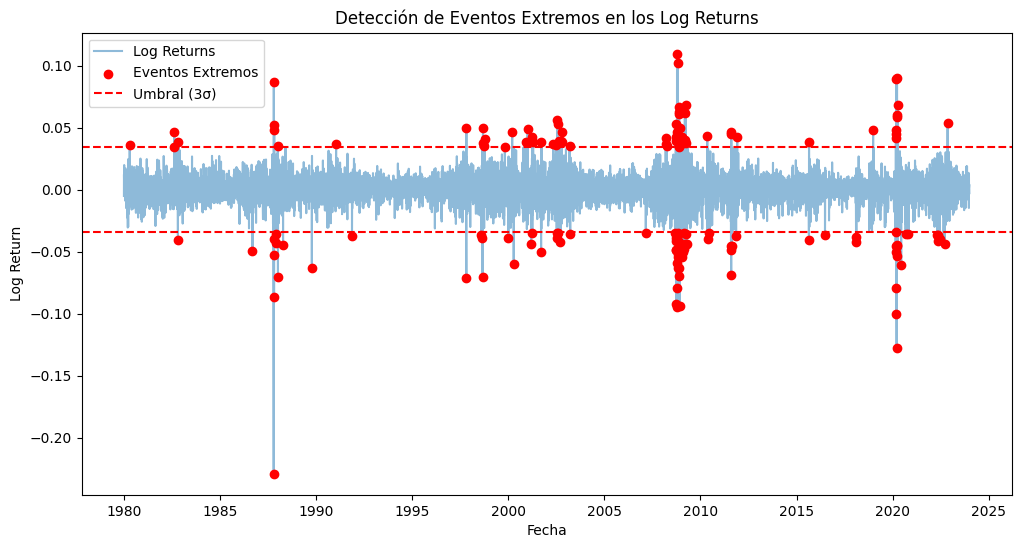

In [65]:
# Calcular el umbral como, por ejemplo, 3 desviaciones estándar por encima o por debajo de la media
mean_return = sp500['Log Return'].mean()
std_return = sp500['Log Return'].std()
threshold = mean_return + 3 * std_return

extreme_events = sp500['Log Return'].copy()
# Detectar eventos extremos por encima del umbral y por debajo de menos el umbral
for index, log_return in zip(sp500['Log Return'].index, sp500['Log Return']):
    if log_return < threshold and log_return > -threshold:
        extreme_events[index] = np.nan
    
extreme_events.dropna(inplace=True)

# Graficar los eventos extremos
plt.figure(figsize=(12, 6))
plt.plot(sp500['Log Return'], label="Log Returns", alpha=0.5)
plt.scatter(extreme_events.index, extreme_events, color='red', label="Eventos Extremos", zorder=5)
plt.axhline(threshold, color='red', linestyle='--', label="Umbral (3σ)")
plt.axhline(-threshold, color='red', linestyle='--')
plt.xlabel("Fecha")
plt.ylabel("Log Return")
plt.title("Detección de Eventos Extremos en los Log Returns")
plt.legend()
plt.show()


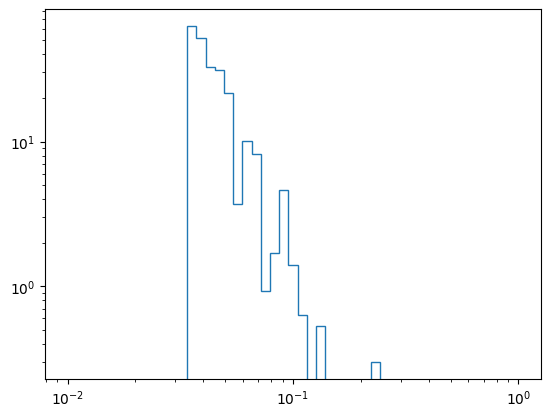

In [70]:
bins = np.logspace(-2, 0, 50)
counts, bins, _ = plt.hist(np.abs(extreme_events), bins=bins, density=True, histtype='step')
plt.xscale("log")
plt.yscale("log")


Miro ventanas diferentes a un solo día

In [ ]:
# Definir diferentes ventanas de tiempo (en días)
ventanas = [1, 5, 10, 20]  # 1 día, 1 semana, 2 semanas, 1 mes

for ventana in ventanas:
    sp500[f'Return_{ventana}d'] = np.log(sp500['Adj Close'] / sp500['Adj Close'].shift(ventana))

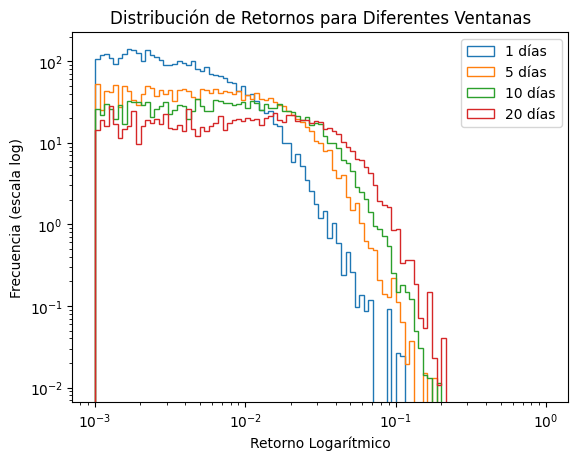

In [29]:
bins = np.logspace(-3, 0, 100)

# Graficar las distribuciones de los retornos para diferentes ventanas
# plt.figure(figsize=(12, 8))
for ventana in ventanas:
    plt.hist(sp500[f'Return_{ventana}d'].dropna(), bins=bins, label=f'{ventana} días', histtype='step', density=True)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Retorno Logarítmico")
plt.ylabel("Frecuencia (escala log)")
plt.title("Distribución de Retornos para Diferentes Ventanas")
plt.legend()
plt.show()


Y con el bitcoin?

[*********************100%***********************]  1 of 1 completed


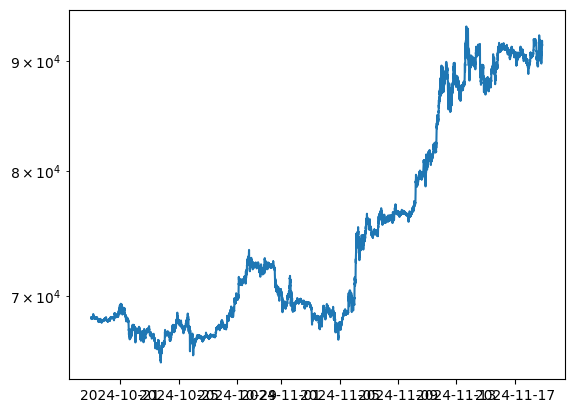

In [94]:
btc = yf.download("BTC-USD", start='2024-09-20', end=None, interval="2m")

plt.plot(btc['Adj Close'])
plt.yscale('log')

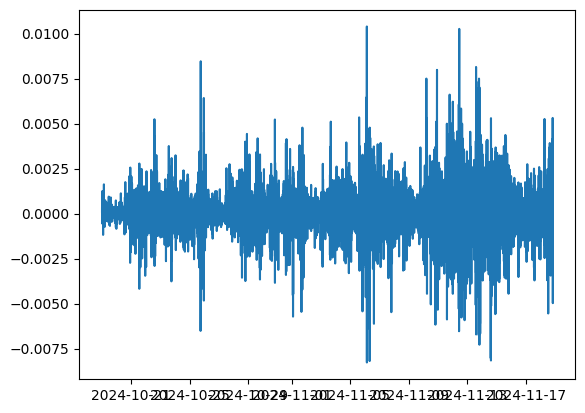

In [95]:
btc['Log Return'] = np.log(btc['Adj Close'] / btc['Adj Close'].shift(1))
btc.dropna(inplace=True)

plt.plot(btc['Log Return'])

In [2]:
# Histograma de los retornos absolutos
plt.figure(figsize=(10, 6))

bins = np.logspace(-3, -1.5, 100)

counts, bins, _  = plt.hist(np.abs(btc['Log Return']), bins=bins, density=True, histtype='step')

x = (bins[:-1] + bins[1:]) / 2

# Ajustar una distribución de potencia a los datos
start = 20
end = 65
plt.axvline(x[start], color='r', linestyle='--', label='Inicio del ajuste')
plt.axvline(x[end], color='r', linestyle='--', label='Fin del ajuste')

x_fit = x[start:end]
y_fit = counts[start:end]

# Borro los valores 0 para que no haya problemas al hacer el ajuste
x_fit = x_fit[y_fit > 0]
y_fit = y_fit[y_fit > 0]

popt, pcov = np.polyfit(np.log(x_fit), np.log(y_fit), 1, cov=True)
alpha = -popt[0]
beta = np.exp(popt[1])

plt.plot(x_fit, beta * x_fit ** (-alpha), label=f'Potencia: {alpha:.2f} +- {np.sqrt(pcov[0, 0]):.2f}')

plt.legend()


plt.xscale("log")
plt.yscale("log")

plt.xlabel("Retorno Absoluto")
plt.ylabel("Frecuencia (escala logarítmica)")

NameError: name 'btc' is not defined

<Figure size 1000x600 with 0 Axes>

Probando el método de Wavelet del paper de Bartolozzi

Curtosis: 248.68240672201833
Asimetría: -4.036072789399461


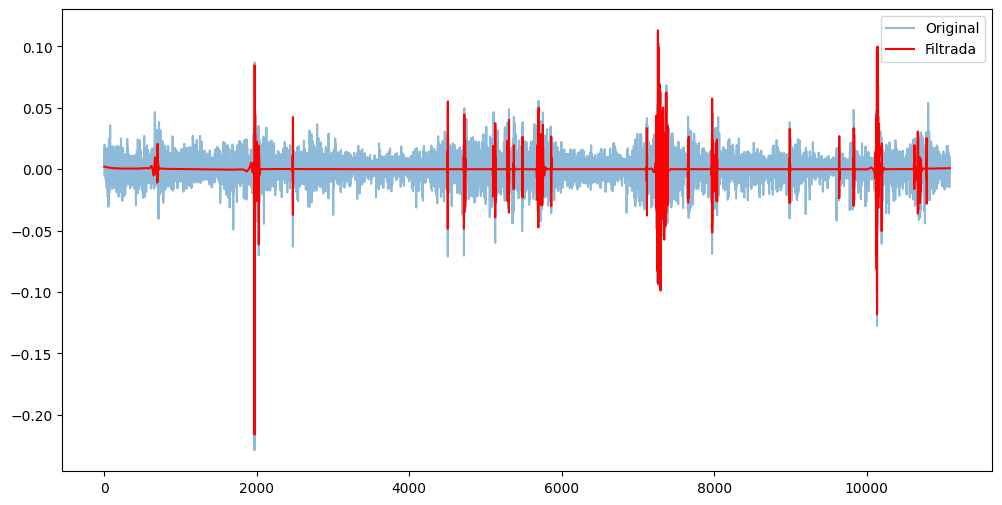

In [33]:
# Supón que 'log_returns' es tu serie temporal de retornos logarítmicos
log_returns = sp500['Log Return'].values

# Realiza la descomposición wavelet con la wavelet Daubechies de orden 4
wavelet = 'db4'
coeffs = pywt.wavedec(log_returns, wavelet)

# Filtra los coeficientes eliminando los de baja energía
threshold = 0.4 * np.max(coeffs[-1])  # Ajusta este umbral según sea necesario
filtered_coeffs = [pywt.threshold(c, threshold, mode='hard') for c in coeffs]

# Reconstruye la serie temporal filtrada
filtered_log_returns = pywt.waverec(filtered_coeffs, wavelet)

kurtosis = stats.kurtosis(filtered_log_returns)
skewness = stats.skew(filtered_log_returns)
print("Curtosis:", kurtosis)
print("Asimetría:", skewness)

# Graficar la serie original y la filtrada
plt.figure(figsize=(12, 6))
plt.plot(log_returns, label='Original', alpha=0.5)
plt.plot(filtered_log_returns, label='Filtrada', color='red')
plt.legend()
plt.show()

In [34]:
epsilon = 0.01  # Ajusta este valor según sea necesario
indices_avalanchas = np.where(np.abs(filtered_log_returns) > epsilon)[0]

# Identificar periodos de avalanchas (donde los índices están contiguos)
avalanchas = []
inicio = indices_avalanchas[0]
for i in range(1, len(indices_avalanchas)):
    if indices_avalanchas[i] != indices_avalanchas[i - 1] + 1:
        avalanchas.append((inicio, indices_avalanchas[i - 1]))
        inicio = indices_avalanchas[i]
avalanchas.append((inicio, indices_avalanchas[-1]))  # Agregar la última avalancha


In [35]:
volumenes = []
for inicio, fin in avalanchas:
    volumen = np.sum(filtered_log_returns[inicio:fin]**2)
    volumenes.append(volumen)

duraciones = [fin - inicio + 1 for inicio, fin in avalanchas]
tiempos_espera = [
    avalanchas[i + 1][0] - avalanchas[i][1] for i in range(len(avalanchas) - 1)
]


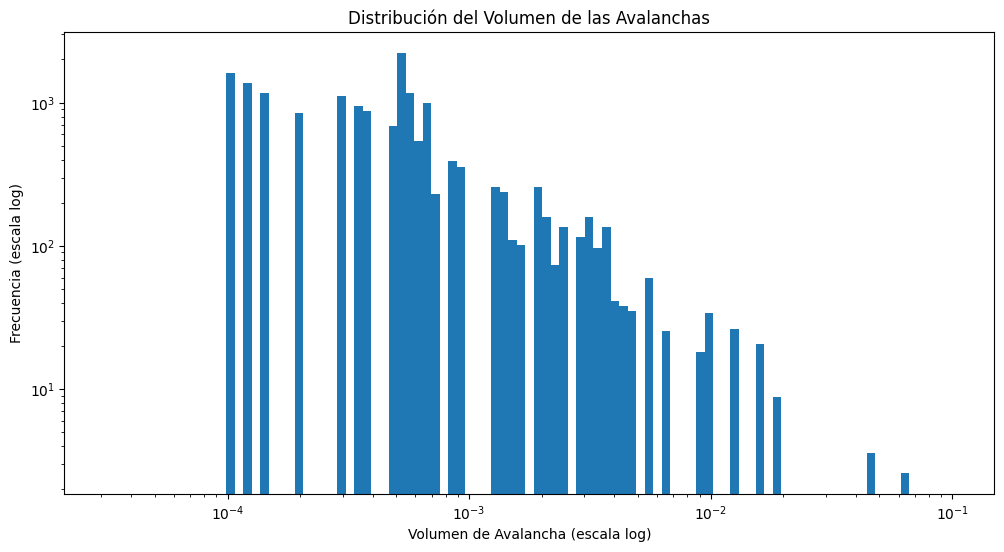

In [36]:
bins = np.logspace(-4.5, -1, 100)
plt.figure(figsize=(12, 6))
plt.hist(volumenes, bins=bins, density=True)
plt.xlabel("Volumen de Avalancha (escala log)")
plt.ylabel("Frecuencia (escala log)")

plt.xscale("log")
plt.yscale("log")

plt.title("Distribución del Volumen de las Avalanchas")
plt.show()